# Import Packages

## Standard Packages

## Installed Packages

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
import pandas as pd

In [2]:
import networkx as nx
import numpy as np

## Custom Packages

In [3]:
import fuzzyjoin.tokenization.token_process as tp
import fuzzyjoin.data_cleaning.data_cleaning as dc
import fuzzyjoin.similarity_scores.similarity_scores as sim
import fuzzyjoin.token_ordering.basic_token_ordering_RS_join as bto
import fuzzyjoin.helpers as H
import fuzzyjoin.kernel.basic_kernel_RSJoin as bk

# Custom Functions

## String Distance Functions

In [4]:
def levenshtein_distance(s, t):
    # From https://en.wikipedia.org/wiki/Levenshtein_distance#Iterative_with_full_matrix
    # TODO: How to handle None values for this and for Jaccard distance
    
    m = len(s)
    n = len(t)
    
    
    # For all i and j, d[i, j] will hold the Levenshtein distance between
    # the first i characters of s and the first j characters of t
    d = np.zeros(shape=(m+1, n+1))
    
    # Source prefixes can be transformed into empty string by
    # dropping all characters
    for i in range(m):
        d[i+1, 0] = i+1
    
    # Target prefixes can be reached from empty source prefix
    # by inserting every character
    for j in range(n):
        d[0, j+1] = j+1
    
    for j in range(n):
        for i in range(m):
            if s[i] == t[j]:
                substitution_cost = 0
            else:
                substitution_cost = 1
            d[i+1, j+1] = min(d[i, j+1] + 1,                  # Deletion
                              d[i+1, j] + 1,                  # Insertion
                              d[i, j] + substitution_cost     # Substitution
                             )
    return d[m, n]

In [5]:
assert levenshtein_distance(s="kitten", t="sitting") == 3

In [6]:
assert levenshtein_distance(s="kitten", t="kitten") == 0

In [7]:
assert levenshtein_distance(s="flaw", t="lawn") == 2

## Highly Connected Subgraph Clustering

In [8]:
# Adapted from https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py
def highly_connected(G, E):
    """Checks if the graph G is highly connected
    Highly connected means, that splitting the graph G into subgraphs needs more than 0.5*|V| edge deletions
    This definition can be found in Section 2 of the publication.
    :param G: Graph G
    :param E: Edges needed for splitting G
    :return: True if G is highly connected, otherwise False
    """

    return len(E) > len(G.nodes) / 2


def remove_edges(G, E):
    """Removes all edges E from G
    Iterates over all edges in E and removes them from G
    :param G: Graph to remove edges from
    :param E: One or multiple Edges
    :return: Graph with edges removed
    """

    for edge in E:
        G.remove_edge(*edge)
    return G


def HCS(G):
    """Basic HCS Algorithm
    cluster labels, removed edges are stored in global variables
    :param G: Input graph
    :return: Either the input Graph if it is highly connected, otherwise a Graph composed of
    Subgraphs that build clusters
    """
    # NOTE: Minimum edge cut appears to depend on order of edges added to graph
    E = nx.algorithms.connectivity.cuts.minimum_edge_cut(G)
    
    if E == G.edges(): # Base case - Minimum cut produces singletons
        return G

    if not highly_connected(G, E):
        G = remove_edges(G, E)
        sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        if len(sub_graphs) == 2:
            H = HCS(sub_graphs[0])
            _H = HCS(sub_graphs[1])

            G = nx.compose(H, _H)

    return G

def labelled_HCS(G):
    """
    Runs basic HCS and returns Cluster Labels
    :param G: Input graph
    :return: List of cluster assignments for the single vertices
    """

    _G = HCS(G)

    sub_graphs = (G.subgraph(c).copy() for c in nx.connected_components(_G))


    labels = np.zeros(shape=(len(G)), dtype=np.uint16)
    # Assumes that graph nodes are 0-indexed

    for _class, _cluster in enumerate(sub_graphs, 1):
        c = list(_cluster.nodes)
        labels[c] = _class

    return labels

In [9]:
G_test = nx.Graph()
G_test.add_edges_from([(1,2),(2,3),(3,4),(4,5),(5,1),(1,4),(2,4),(3,5),
                       (2,'y'),('b',3),('a','A'),('A','B'),('B','b'),('A','b'),('B','a'),
                      ('x','y'),('y','z'),('x','z'),('z','a'),('a','b'),('b','y')
                       ])
G_test_subgraphs = [nx.Graph(G_test.subgraph(['x','y','z'])), nx.Graph(G_test.subgraph(['a','b','A', 'B'])),
                   nx.Graph(G_test.subgraph([1,2,3,4,5]))]
G_test_subgraphs = nx.algorithms.operators.all.compose_all(G_test_subgraphs)
assert nx.is_isomorphic(HCS(G_test), G_test_subgraphs)

In [10]:
G_test = nx.Graph()
G_test.add_edges_from([(1,2)])
assert nx.is_isomorphic(HCS(G_test), G_test)

In [11]:
def HCS_per_cc(G):
    '''Wrapper that calculates Highly Connected Subgraphs per connected component'''
    if nx.is_connected(G):
        G_HCS = HCS(G)
    else:
        new_graphs = []
        for g in nx.connected_components(G):
            g = nx.Graph(G.subgraph(g))
            g_HCS = HCS(g)
            new_graphs.append(g_HCS)
        G_HCS = nx.algorithms.operators.all.compose_all(new_graphs)
    return G_HCS

In [12]:
G_test_subgraphs = [nx.Graph(G_test.subgraph(['x','y','z'])), nx.Graph(G_test.subgraph(['a','b','A', 'B'])),
                   nx.Graph(G_test.subgraph([1,2,3,4,5]))]
G_test_subgraphs = nx.algorithms.operators.all.compose_all(G_test_subgraphs)
assert nx.is_isomorphic(HCS_per_cc(G_test_subgraphs), G_test_subgraphs)

In [46]:
def labelled_HCS_per_cc(G):
    """
    Runs basic HCS and returns Cluster Labels
    :param G: Input graph
    :return: List of cluster assignments for the single vertices
    """

    _G = HCS_per_cc(G)

    sub_graphs = (G.subgraph(c).copy() for c in nx.connected_components(_G))


    labels = {}

    for _class, _cluster in enumerate(sub_graphs, 1):
        nodes = list(_cluster.nodes)
        for node in nodes:
            labels[node] = _class

    return labels

In [47]:
G_test = nx.Graph()
G_test.add_edges_from([(1,2),(2,3),(3,4),(4,5),(5,1),(1,4),(2,4),(3,5),
                       (2,'y'),('b',3),('a','A'),('A','B'),('B','b'),('A','b'),('B','a'),
                      ('x','y'),('y','z'),('x','z'),('z','a'),('a','b'),('b','y')
                       ])
assert labelled_HCS_per_cc(G_test) == {1: 1, 2: 1, 3:1, 4: 1, 5:1,
                                      'x': 2, 'y': 2, 'z': 2,
                                      'a': 3, 'b': 3, 'A': 3, 'B': 3}

# Start Spark Session

In [4]:
sc = SparkContext()
spark = SparkSession.builder.getOrCreate()

# Load DBLP Dataset

In [6]:
df_R = spark.read.csv(path='dblp.raw.txt.gz', 
                      sep=':', 
                      schema='dblp_id STRING, publication_title STRING, authors STRING, other_info STRING')

## Take Random Sample of Dataset

In [7]:
df_R = df_R.sample(fraction=0.05)

In [8]:
n_R = df_R.count()

# Load CITSEERX Dataset

In [9]:
df_S = spark.read.csv(path="csx.raw.txt.gz", 
                      sep=':', 
                      schema='csx_id STRING, publication_title STRING, authors STRING, other_info STRING')

## Take Random Sample of Dataset

In [10]:
df_S = df_S.limit(50000)
# TODO: `df_S.sample(fraction=0.01).count()` results in `java.io.EOFException: Unexpected end of input stream` error

In [11]:
n_S = df_S.count()

# Add record ID

In [12]:
df_R = H.create_record_id(df=df_R)
df_S = H.create_record_id(df=df_S)

# Setup join attributes

In [13]:
df_R = H.create_join_attribute(df=df_R, 
                               join_columns=['publication_title','authors'], 
                               record_data="2,3")
        
df_S = H.create_join_attribute(df=df_S, 
                               join_columns=['publication_title','authors'], 
                               record_data="2,3")

# Basic Token Ordering

In [14]:
token_ordering = bto.bto_RS_Join(df_R=df_R, n_R=n_R, df_S=df_S, n_S=n_S, 
                                 join_R='join_attribute', join_S='join_attribute')
token_ordering_list = token_ordering.collect()

# RID-Pair Generation - Basic Kernel

In [15]:
similar_pairs = bk.basic_kernel_RSJoin(df_R=df_R, RID_name_R="dblp_id", 
                                       join_attribute_name_R="join_attribute", 
                            df_S=df_S, RID_name_S="csx_id", 
                                       join_attribute_name_S="join_attribute", 
                            token_ordering=token_ordering_list, sim_threshold=0.7)

# Record Join

In [16]:
if not similar_pairs.isEmpty():
    df_similar_pairs = spark.createDataFrame(similar_pairs, ["RID1", "RID2", "JaccardSimilarity"])
    df_similar_pairs = df_similar_pairs.join(df_R, df_similar_pairs.RID1 == df_R.dblp_id).join(df_S, df_similar_pairs.RID2 == df_S.csx_id)
    df_similar_pairs = df_similar_pairs.toPandas()
    df_similar_pairs.columns = ["RID1","RID2","JaccardSimilarity","dblp_id","dblp_publication_title",
                            "dblp_authors","dblp_other_info","RID1_copy", "dblp_join_attribute",
                            "csx_id","csx_publication_title",
                            "csx_authors","csx_other_info","RID2_copy", "csx_join_attribute"]

    df_similar_pairs = df_similar_pairs.sort_values(by=["dblp_id", "csx_id"]).reset_index(drop=True)

In [ ]:
# DBLP and CITSEERX don't have any other attributes in common besides publication title and authors,
# limiting ability to perform ML-based entity resolution

# Other DBLP attributes: publication date, publication journalor conference, and publication medium
# Other CITSEERX attributes: abstract and URLs to publication's references

In [17]:
df_similar_pairs.to_csv("DBLP_CSX_sample.csv")

In [13]:
df_similar_pairs = pd.read_csv("DBLP_CSX_sample.csv")

In [14]:
df_similar_pairs = df_similar_pairs.drop(['Unnamed: 0'], axis=1)

# Graph Representation

In [15]:
G = nx.from_pandas_edgelist(df=df_similar_pairs, source="dblp_id", target="csx_id", 
                            edge_attr="JaccardSimilarity")

In [16]:
G.number_of_edges()

887

In [17]:
G.number_of_nodes()

1704

# Highly Connected Subgraph Clustering

In [20]:
print(max([len(g) for g in nx.connected_components(G)]))
print(min([len(g) for g in nx.connected_components(G)]))

29
2


In [21]:
G_new = HCS_per_cc(G)

In [22]:
print(max([len(g) for g in nx.connected_components(G_new)]))
print(min([len(g) for g in nx.connected_components(G_new)]))
# All connected components are pairs or singletons

2
1


In [23]:
G_new.number_of_nodes()

1704

In [24]:
G_new.number_of_edges()

821

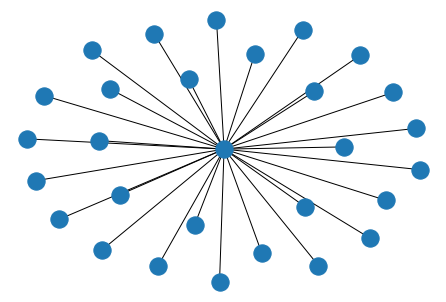

In [118]:
nx.draw(G.subgraph({'conf/er/C96w1',
  'oai CiteSeerXPSU 10.1.1.1.2277',
  'oai CiteSeerXPSU 10.1.1.10.3741',
  'oai CiteSeerXPSU 10.1.1.10.7305',
  'oai CiteSeerXPSU 10.1.1.10.8229',
  'oai CiteSeerXPSU 10.1.1.100.2943',
  'oai CiteSeerXPSU 10.1.1.100.3395',
  'oai CiteSeerXPSU 10.1.1.100.3726',
  'oai CiteSeerXPSU 10.1.1.100.515',
  'oai CiteSeerXPSU 10.1.1.100.539',
  'oai CiteSeerXPSU 10.1.1.100.5453',
  'oai CiteSeerXPSU 10.1.1.100.5550',
  'oai CiteSeerXPSU 10.1.1.100.7164',
  'oai CiteSeerXPSU 10.1.1.100.8526',
  'oai CiteSeerXPSU 10.1.1.100.8549',
  'oai CiteSeerXPSU 10.1.1.100.947',
  'oai CiteSeerXPSU 10.1.1.101.2012',
  'oai CiteSeerXPSU 10.1.1.101.4696',
  'oai CiteSeerXPSU 10.1.1.101.5369',
  'oai CiteSeerXPSU 10.1.1.101.8481',
  'oai CiteSeerXPSU 10.1.1.101.9047',
  'oai CiteSeerXPSU 10.1.1.102.1752',
  'oai CiteSeerXPSU 10.1.1.102.6393',
  'oai CiteSeerXPSU 10.1.1.102.7043',
  'oai CiteSeerXPSU 10.1.1.102.8864',
  'oai CiteSeerXPSU 10.1.1.102.9978',
  'oai CiteSeerXPSU 10.1.1.103.1216',
  'oai CiteSeerXPSU 10.1.1.103.1961',
  'oai CiteSeerXPSU 10.1.1.103.2953'}))
# HCS on this connected component (below) leads to a graph of singletons and a single pair.
# For this scenario, it works out because the join attributes
# ("Title, Table of Contents." and "Table of Contents") are too generic.
# However, is this what we want in general?

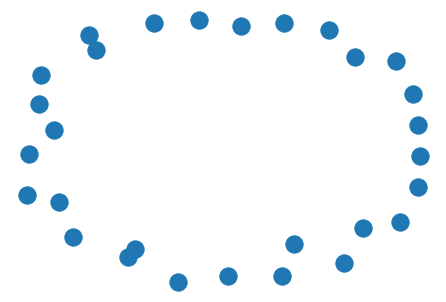

In [19]:
nx.draw(HCS(G.subgraph({'conf/er/C96w1',
  'oai CiteSeerXPSU 10.1.1.1.2277',
  'oai CiteSeerXPSU 10.1.1.10.3741',
  'oai CiteSeerXPSU 10.1.1.10.7305',
  'oai CiteSeerXPSU 10.1.1.10.8229',
  'oai CiteSeerXPSU 10.1.1.100.2943',
  'oai CiteSeerXPSU 10.1.1.100.3395',
  'oai CiteSeerXPSU 10.1.1.100.3726',
  'oai CiteSeerXPSU 10.1.1.100.515',
  'oai CiteSeerXPSU 10.1.1.100.539',
  'oai CiteSeerXPSU 10.1.1.100.5453',
  'oai CiteSeerXPSU 10.1.1.100.5550',
  'oai CiteSeerXPSU 10.1.1.100.7164',
  'oai CiteSeerXPSU 10.1.1.100.8526',
  'oai CiteSeerXPSU 10.1.1.100.8549',
  'oai CiteSeerXPSU 10.1.1.100.947',
  'oai CiteSeerXPSU 10.1.1.101.2012',
  'oai CiteSeerXPSU 10.1.1.101.4696',
  'oai CiteSeerXPSU 10.1.1.101.5369',
  'oai CiteSeerXPSU 10.1.1.101.8481',
  'oai CiteSeerXPSU 10.1.1.101.9047',
  'oai CiteSeerXPSU 10.1.1.102.1752',
  'oai CiteSeerXPSU 10.1.1.102.6393',
  'oai CiteSeerXPSU 10.1.1.102.7043',
  'oai CiteSeerXPSU 10.1.1.102.8864',
  'oai CiteSeerXPSU 10.1.1.102.9978',
  'oai CiteSeerXPSU 10.1.1.103.1216',
  'oai CiteSeerXPSU 10.1.1.103.1961',
  'oai CiteSeerXPSU 10.1.1.103.2953'}).copy()))

# Feature Engineering

## Similarity Metrics

In [29]:
for col in ['dblp_publication_title', 'csx_publication_title', 
            'dblp_authors', 'csx_authors']:
    df_similar_pairs[col+'_enr'] = df_similar_pairs[col].apply(lambda x: dc.string_cleaning(str(x)))

In [30]:
for col in ['publication_title', 'authors']:
    df_similar_pairs[col+'_lev_dist'] = df_similar_pairs[['dblp_'+col+'_enr', 'csx_'+col+'_enr']] \
.apply(lambda x: levenshtein_distance(*x), axis = 1)
    df_similar_pairs[col+'_jacc_dist'] = df_similar_pairs[['dblp_'+col+'_enr', 'csx_'+col+'_enr']] \
.apply(lambda x: sim.jaccard_index(*x), axis = 1)

In [31]:
df_similar_pairs['publication_title_lev_dist'] = df_similar_pairs[['dblp_publication_title_enr', 'csx_publication_title_enr']] \
.apply(lambda x: levenshtein_distance(*x), axis = 1)

In [32]:
df_similar_pairs['publication_title_jacc_dist'] = df_similar_pairs[['dblp_publication_title_enr', 'csx_publication_title_enr']] \
.apply(lambda x: sim.jaccard_index(*x), axis = 1)

In [33]:
df_similar_pairs[['dblp_publication_title', 'csx_publication_title', 
                  'publication_title_lev_dist', 'publication_title_jacc_dist']].head()

dblp_publication_title  \
0  Sketchpad, A Man-Machine Graphical Communicati...   
1                                           Preface.   
2                                           Preface.   
3  Factorization with missing data for 3D structu...   
4                      Managing Trust in Active XML.   

                               csx_publication_title  \
0  Sketchpad  A man-machine graphical communicati...   
1                                            PREFACE   
2                                            PREFACE   
3  c ○ IEEE Factorization with Missing Data for 3...   
4                       Managing Trust in Active XML   

   publication_title_lev_dist  publication_title_jacc_dist  
0                         0.0                          1.0  
1                         0.0                          1.0  
2                         0.0                          1.0  
3                         7.0                          1.0  
4                         0.0                          1.0

In [35]:
df_similar_pairs[['dblp_authors', 'csx_authors', 
                  'dblp_authors_enr', 'csx_authors_enr', 
                  'authors_lev_dist', 'authors_jacc_dist']].head()

dblp_authors  \
0                                 Ivan E. Sutherland   
1                                                NaN   
2                                                NaN   
3             Rui F. C. Guerreiro Pedro M. Q. Aguiar   
4  Etienne Canaud Salima Benbernou Mohand-Said Hacid   

                                  csx_authors  \
0                      Ivan Edward Sutherland   
1                                         NaN   
2                                         NaN   
3      Rui F. C. Guerreiro Pedro M. Q. Aguiar   
4  Etienne Canaud Salima Benbernou Saïd Hacid   

                                    dblp_authors_enr  \
0                                  ivan e sutherland   
1                                                nan   
2                                                nan   
3                 rui f c guerreiro pedro m q aguiar   
4  etienne canaud salima benbernou mohand said hacid   

                              csx_authors_enr  authors_lev_dist  \
0                      ivan edward sutherland               5.0   
1                                         nan               0.0   
2                                         nan               0.0   
3          rui f c guerreiro pedro m q aguiar               0.0   
4  etienne canaud salima benbernou saïd hacid               8.0   

   authors_jacc_dist  
0           0.928571  
1           1.000000  
2           1.000000  
3           1.000000  
4           0.941176

In [165]:
#token_ordering_list.index('preface_1')

104999

In [166]:
#len(token_ordering_list)

106607

### HCS Cluster Label Matching

In [49]:
G_cluster_labels = labelled_HCS_per_cc(G)

In [51]:
df_similar_pairs["dblp_cluster_id"] = df_similar_pairs["dblp_id"].apply(lambda x: G_cluster_labels[x] if x in G_cluster_labels.keys() else None)

In [52]:
df_similar_pairs["csx_cluster_id"] = df_similar_pairs["csx_id"].apply(lambda x: G_cluster_labels[x] if x in G_cluster_labels.keys() else None)

In [55]:
df_similar_pairs["same_hcs_cluster"] = df_similar_pairs["dblp_cluster_id"].eq(df_similar_pairs["csx_cluster_id"])

In [57]:
df_similar_pairs["match"] = None

# Active Learning

In [60]:
for row in df_similar_pairs:
    print(row)

RID1
RID2
JaccardSimilarity
dblp_id
dblp_publication_title
dblp_authors
dblp_other_info
RID1_copy
dblp_join_attribute
csx_id
csx_publication_title
csx_authors
csx_other_info
RID2_copy
csx_join_attribute
dblp_publication_title_enr
csx_publication_title_enr
publication_title_lev_dist
publication_title_jacc_dist
dblp_authors_enr
csx_authors_enr
authors_lev_dist
authors_jacc_dist
dblp_cluster_id
csx_cluster_id
same_hcs_cluster
match


In [ ]:
for index, row in df_similar_pairs.iterrows():
    print("Row Number:", index)
    print("DBLP Publication Title:", row["dblp_publication_title"])
    print("DBLP Authors:", row["dblp_authors"])
    print("CITSEERX Publication Title:", row["csx_publication_title"])
    print("CITSEERX Authors:", row["csx_authors"])
    print("Publication Title Levenshtein Distance:", row["publication_title_lev_dist"])
    print("Publication Title Jaccard Distance:", row["publication_title_jacc_dist"])
    print("Authors Levenshtein Distance:", row["authors_lev_dist"])
    print("Authors Jaccard Distance:", row["authors_jacc_dist"])
    print("Same HCS Cluster?:", row["same_hcs_cluster"])
    try:
        feedback = input("Same? [y/n]").lower()
        if feedback == "y":
            label = 1
        elif feedback == "n":
            label = 0
        else:
            continue
        df_similar_pairs.loc[index, 'label'] = label
    except KeyboardInterrupt:
        print("End active learning")
        break

Row Number: 0
DBLP Publication Title: Sketchpad, A Man-Machine Graphical Communication System
DBLP Authors: Ivan E. Sutherland
CITSEERX Publication Title: Sketchpad  A man-machine graphical communication system
CITSEERX Authors: Ivan Edward Sutherland
Publication Title Levenshtein Distance: 0.0
Publication Title Jaccard Distance: 1.0
Authors Levenshtein Distance: 5.0
Authors Jaccard Distance: 0.9285714285714286
Same HCS Cluster?: True
Same? [y/n]y
Row Number: 1
DBLP Publication Title: Preface.
DBLP Authors: nan
CITSEERX Publication Title: PREFACE
CITSEERX Authors: nan
Publication Title Levenshtein Distance: 0.0
Publication Title Jaccard Distance: 1.0
Authors Levenshtein Distance: 0.0
Authors Jaccard Distance: 1.0
Same HCS Cluster?: True
Same? [y/n]n
Row Number: 2
DBLP Publication Title: Preface.
DBLP Authors: nan
CITSEERX Publication Title: PREFACE
CITSEERX Authors: nan
Publication Title Levenshtein Distance: 0.0
Publication Title Jaccard Distance: 1.0
Authors Levenshtein Distance: 0.0

Same? [y/n]y
Row Number: 18
DBLP Publication Title: Real Perfect Contrast Visual Secret Sharing Schemes with Reversing.
DBLP Authors: Ching-Nung Yang Chung-Chun Wang Tse-Shih Chen
CITSEERX Publication Title: Real Perfect Contrast Visual Secret Sharing Schemes with Reversing
CITSEERX Authors: Ching-nung Yang Chung-chun Wang Tse-shih Chen
Publication Title Levenshtein Distance: 0.0
Publication Title Jaccard Distance: 1.0
Authors Levenshtein Distance: 0.0
Authors Jaccard Distance: 1.0
Same HCS Cluster?: True
Same? [y/n]y
Row Number: 19
DBLP Publication Title: Modular Fair Exchange Protocols for Electronic Commerce.
DBLP Authors: Holger Vogt Henning Pagnia Felix C. Gärtner
CITSEERX Publication Title: Modular Fair Exchange Protocols for Electronic Commerce
CITSEERX Authors: Holger Vogt Henning Pagnia Felix C. Gärtner
Publication Title Levenshtein Distance: 0.0
Publication Title Jaccard Distance: 1.0
Authors Levenshtein Distance: 0.0
Authors Jaccard Distance: 1.0
Same HCS Cluster?: True
Same

# TODO:
1. Consider calculating weighted Jaccard score, based on:

    - token ordering list,

    - log of token frequency, 

    - and/or tf-idf

2. Active Learning (labeling of matches based on HCS clustering and feature engineering)

3. Consider adaptive variant of Levenshtein distance for efficiency

4. Other distance metrics (Damerau–Levenshtein distance, Jaro)

5. End result: Data frame with canonicalized publication titles and authors, along with non-overlapping features from both datasets